In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import bbi
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import bioframe as bf
import cooltools
import cooltools.lib.plotting
import cooler
import LoopsManipulation
import ReaderFunctions
from matplotlib.colors import LogNorm

In [16]:
#### A way to use externel fonts in matplotlib without installing it
from matplotlib import font_manager
font_dirs = ['/users/ankit.gupta/.fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
#### A way to use externel fonts in matplotlib without installing it

mpl.rcParams['font.family'] = 'Nunito'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2

## Loading loops and TIR peaks positions

In [3]:
wtLoops = f'/groups/goloborodko/projects/ankit/spt5_project/mustache_loops/mm9/WT/WT.5kb.tsv'
koLoops = f'/groups/goloborodko/projects/ankit/spt5_project/mustache_loops/mm9/KO/KO.5kb.tsv'
loops = pd.concat((ReaderFunctions.GetMustacheLoops(wtLoops), 
                   ReaderFunctions.GetMustacheLoops(koLoops)))
loops = LoopsManipulation.MergeLoops(loops, 
                                     iterations=50, 
                                     randomSeed=2, 
                                     flank=5000
                                    )

In [4]:
loops = loops.drop("FDR",axis=1)
loops = loops.rename(columns={"distance":"loop_len"})

In [5]:
loops

,chrom1,start1,end1,chrom2,start2,end2,loop_len
0,chr1,4480000,4485000,chr1,4755000,4760000,275000
1,chr1,9540000,9545000,chr1,9690000,9695000,150000
2,chr1,9550000,9555000,chr1,10100000,10105000,550000
3,chr1,9560000,9565000,chr1,9685000,9690000,125000
4,chr1,9710000,9715000,chr1,10075000,10080000,365000
...,...,...,...,...,...,...,...
17978,chrX,163455000,163460000,chrX,163665000,163670000,210000
17979,chrX,163540000,163545000,chrX,163645000,163650000,105000
17980,chrX,163720000,163725000,chrX,163795000,163800000,75000
17981,chrX,163935000,163940000,chrX,164255000,164260000,320000


## Getting the loop strength from the loops

In [6]:
microCRes = 5000
cools = {}
cools["WT"] = cooler.Cooler(f"/groups/goloborodko/projects/lab/pavri-spt5/mm9/distiller_0.3.3/results/coolers_library_group/WT.mm9.mapq_30.100.mcool::resolutions/{microCRes}")
cools["KO"] = cooler.Cooler(f"/groups/goloborodko/projects/lab/pavri-spt5/mm9/distiller_0.3.3/results/coolers_library_group/KO.mm9.mapq_30.100.mcool::resolutions/{microCRes}")
mm9_chromsizes = bf.fetch_chromsizes('mm9')
mm9_cens = bf.fetch_centromeres('mm9') ### Mouse chromosomes are telocentric
mm9_chroms = bf.core.construction.add_ucsc_name_column(bf.make_chromarms(mm9_chromsizes,  mm9_cens))
mm9_chroms = mm9_chroms[mm9_chroms.chrom.isin(cools["WT"].chromnames)].reset_index(drop=True)

In [7]:
%%time

expectedWT = pd.read_csv(f"../microC_pileups/expected_cis_WT_group_{microCRes//1000}kb_res.tsv",sep="\t")
expectedKO = pd.read_csv(f"../microC_pileups/expected_cis_KO_group_{microCRes//1000}kb_res.tsv",sep="\t")

loopsFlank = 200_000

loopStrengthPileup = dict(WT=cooltools.pileup(cools["WT"], loops, view_df=mm9_chroms,expected_df=expectedWT, flank=loopsFlank, nproc=10), 
                          KO=cooltools.pileup(cools["KO"], loops, view_df=mm9_chroms,expected_df=expectedKO, flank=loopsFlank, nproc=10))

CPU times: user 19.8 s, sys: 13.8 s, total: 33.6 s
Wall time: 2min 27s


In [8]:
loops[f"WT_loop_str"] = np.nanmean(loopStrengthPileup["WT"],axis=(0,1))
loops[f"KO_loop_str"] = np.nanmean(loopStrengthPileup["KO"],axis=(0,1))
loops[f"log2(KO/WT)_loop_str"] = np.log2(loops[f"KO_loop_str"]/loops[f"WT_loop_str"])

<ipython-input-8-9b11f9e96f01>:1: RuntimeWarning: Mean of empty slice
  loops[f"WT_loop_str"] = np.nanmean(loopStrengthPileup["WT"],axis=(0,1))
<ipython-input-8-9b11f9e96f01>:2: RuntimeWarning: Mean of empty slice
  loops[f"KO_loop_str"] = np.nanmean(loopStrengthPileup["KO"],axis=(0,1))


In [9]:
loops

,chrom1,start1,end1,chrom2,start2,end2,loop_len,WT_loop_str,KO_loop_str,log2(KO/WT)_loop_str
0,chr1,4480000,4485000,chr1,4755000,4760000,275000,0.893406,0.815914,-0.130898
1,chr1,9540000,9545000,chr1,9690000,9695000,150000,0.668394,0.686429,0.038413
2,chr1,9550000,9555000,chr1,10100000,10105000,550000,1.090138,1.293448,0.246712
3,chr1,9560000,9565000,chr1,9685000,9690000,125000,0.717867,0.732185,0.028491
4,chr1,9710000,9715000,chr1,10075000,10080000,365000,1.525778,1.750100,0.197893
...,...,...,...,...,...,...,...,...,...,...
17978,chrX,163455000,163460000,chrX,163665000,163670000,210000,1.407320,1.289188,-0.126488
17979,chrX,163540000,163545000,chrX,163645000,163650000,105000,1.429488,1.334450,-0.099253
17980,chrX,163720000,163725000,chrX,163795000,163800000,75000,0.905209,0.913354,0.012923
17981,chrX,163935000,163940000,chrX,164255000,164260000,320000,1.290232,1.138834,-0.180074


## MicroC Pileups

> 300kb	17983
CPU times: user 13.2 s, sys: 7.11 s, total: 20.3 s
Wall time: 19 s


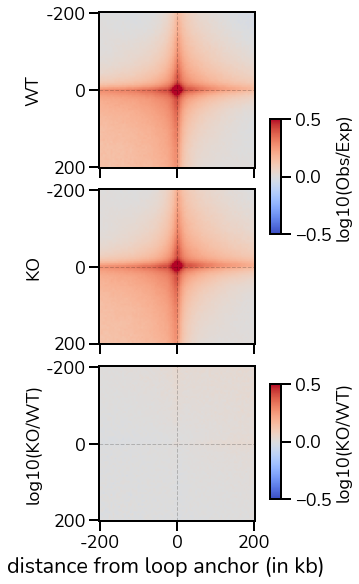

In [19]:
%%time

pileupKwargsDictOE = dict(cmap="coolwarm",vmin=-0.50,vmax=0.50,aspect="auto")
pileupKwargsDictRatio = dict(cmap="coolwarm",vmin=-0.5,vmax=0.5,aspect="auto")

fig,ax = plt.subplots(3,1,figsize=(4,8),sharex=True,sharey=True,constrained_layout=True)

centerAt = loopsFlank // microCRes
ax[0].set_xticks([0,centerAt,centerAt*2],[-loopsFlank//1000,0,loopsFlank//1000])
ax[0].set_yticks([0,centerAt,centerAt*2],[-loopsFlank//1000,0,loopsFlank//1000])
ax[0].set_ylabel("WT")
ax[1].set_ylabel("KO")
ax[2].set_ylabel("log10(KO/WT)")

# ax[0].set_title(i)
pileupKwargsDict = pileupKwargsDictOE
df = loops
print(i,len(df),sep="\t")

covWT = loopStrengthPileup["WT"][:,:,list(df.index)].copy()
ax[0].imshow(np.log10(np.nanmean(covWT,axis=2)),**pileupKwargsDict)
ax[0].axvline(centerAt, lw=1, alpha=0.2, ls="--", c="k")
ax[0].axhline(centerAt, lw=1, alpha=0.2, ls="--", c="k")
ax[0].set_aspect(1)
# ax[0].spines.bottom.set_visible(False)
# ax[0].spines.left.set_visible(False)

covKO = loopStrengthPileup["KO"][:,:,list(df.index)].copy()
ax[1].imshow(np.log10(np.nanmean(covKO,axis=2)),**pileupKwargsDict)
ax[1].axvline(centerAt, lw=1, alpha=0.2, ls="--", c="k")
ax[1].axhline(centerAt, lw=1, alpha=0.2, ls="--", c="k")
ax[1].set_aspect(1)
# ax[1].spines.bottom.set_visible(False)
# ax[1].spines.left.set_visible(False)

pileupKwargsDict = pileupKwargsDictRatio
ratio = np.log10(np.nanmean(covKO,axis=2)/np.nanmean(covWT,axis=2))
ax[2].imshow(ratio,**pileupKwargsDict)
ax[2].axvline(centerAt, lw=1, alpha=0.2, ls="--", c="k")
ax[2].axhline(centerAt, lw=1, alpha=0.2, ls="--", c="k")
ax[2].set_aspect(1)
# ax[2].spines.bottom.set_visible(False)
# ax[2].spines.left.set_visible(False)

ax2 = fig.add_axes([0.86, 0.6,0.04, 0.2])
cb2 = mpl.colorbar.ColorbarBase(ax2, orientation='vertical', 
                               cmap='coolwarm',norm=mpl.colors.Normalize(-0.50, 0.50),label="log10(Obs/Exp)")

ax3 = fig.add_axes([0.86, 0.14,0.04, 0.2])
cb3 = mpl.colorbar.ColorbarBase(ax3, orientation='vertical', 
                               cmap='coolwarm',norm=mpl.colors.Normalize(-0.50, 0.50),label="log10(KO/WT)")

# fig.suptitle(f"Pileups at loops $\pm$ {loopsFlank//1000}kb (Obs/Exp) at different length ranges ({microCRes//1000}kb MicroC)")
# fig.supylabel("distance from left loop anchor (in kb)")
fig.supxlabel("distance from loop anchor (in kb)")

# plt.savefig("microC_pileup_at_loops_all.png",dpi=300,bbox_inches="tight")
# plt.savefig("microC_pileup_at_loops_all.pdf",dpi=300,bbox_inches="tight")